In [1]:
import collections
import datetime
from dateutil import rrule
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web

Holding = collections.namedtuple('Holding', 'ticker percent description')

# Dollars initially invested
initial_investment = 100000

# collect data for this time period
start = '2017-01-05'
end = '2020-01-05'
start = datetime.datetime.strptime(start, "%Y-%m-%d").date() # Convert to date
end = datetime.datetime.strptime(end, "%Y-%m-%d").date()

# Portfolio: Ticker, percentage of holdings, description
portfolio = {
    'name': 'Scotia Funds Portfolio',
    'holdings': [
        Holding('0P000070D4.TO', 35, 'Scotia US Index'),
        Holding('0P000073OF.TO', 50, 'Scotia Nasdaq Index'),
        Holding('0P000070IZ.TO', 10, 'Scotia European'),
        Holding('0P0000SNHN.TO',  5, 'Scotia Private Emerging Markets Pool')
    ]
}

# Baseline benchmark
benchmark_portfolio = {
    'name': 'S&P 500 Benchmark',
    'holdings': [Holding('^GSPC', 100, 'S&P 500')]
}

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Download the history of the portfolio.  Downsample as weekly data.
# Also create the initial share allocation for the portfolio at the start date
# Return a tuple of:
#  - dataframe with a time index + 1 column per ticker (named the ticker symbol) 
#  - dataframe of number of shares per holding
def download_portfolio_history(portfolio, start, end):
    # For each fund, read the raw data and prepare weekly summaries
    raw_data = []
    weekly_data = []
    for fund in portfolio['holdings']:
        # print(f"Fund = {fund[0]}")
        df = web.DataReader(name=fund.ticker, data_source='yahoo', start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d')) # Get raw data
        raw_data.append(df)
        weekly = df.asfreq('W-FRI', method='pad') # Get weekly summary
        weekly = weekly[['Close']].copy() # Just keep the 'Close' column
        weekly.columns = [fund.ticker if x=='Close' else x for x in weekly.columns] # Rename 'Close' to fund_name
        weekly_data.append(weekly)

    # Concatenate to single dataframe. Index by time, one column per ticker.
    portfolio_data = pd.concat(weekly_data, axis=1)
    # Fill in missing data
    portfolio_data = portfolio_data.fillna(method='pad').fillna(method='backfill')

    # Create dataframe to hold number of shares of each holding. Column name is the ticker symbol
    index = pd.date_range(datetime.datetime.now().date(), periods=0, freq='W')
    columns = [fund.ticker for fund in portfolio['holdings']]
    portfolio_num_shares = pd.DataFrame(index=index, columns=columns)
    
    # Calculate the number of shares per holding based on 
    # their book value + percentage in the portfolio + total initial investment
    num_shares = []
    for fund in portfolio["holdings"]:
        index =  portfolio_data.index.get_loc(start, method='nearest')
        share_price = portfolio_data.iloc[index][fund.ticker]
        num = initial_investment * fund.percent / 100
        num = num / share_price
        num_shares.append(num)

    # Add row to dataframe
    portfolio_num_shares.loc[start] = num_shares
    
    return (portfolio_data, portfolio_num_shares)

# Rebalance holdings yearly
def rebalance_portfolio(portfolio, portfolio_data, portfolio_num_shares, start, end):
    rebalanced_num_shares = portfolio_num_shares.copy()

    # Rebalance holding at year end
    for dt in rrule.rrule(rrule.YEARLY, dtstart=start, until=end):
        year_end = datetime.date(dt.year, 12, 31)
        if (year_end > end):
            break

        # Rebalance current investment
        current_investment = portfolio_value(portfolio, portfolio_data, rebalanced_num_shares, at_date=dt)
        num_shares_index =  rebalanced_num_shares.index.get_loc(dt, method='nearest') # both shoud be pad 
        data_index =  portfolio_data.index.get_loc(dt, method='nearest')
        num_shares = []
        for fund in portfolio["holdings"]:
            share_price = portfolio_data.iloc[data_index][fund.ticker]
            num = current_investment * fund.percent / 100
            num = num / share_price
            num_shares.append(num)

        # Add row to dataframe
        rebalanced_num_shares.iloc[num_shares_index] = num_shares

    return rebalanced_num_shares

# Calculate total investment value at given date
def portfolio_value(portfolio, portfolio_data, portfolio_num_shares, at_date, ticker = None) -> float:
    # Sum all the portfolios
    index = portfolio_data.index.get_loc(at_date, method='nearest')
    index_num_shares = portfolio_num_shares.index.get_loc(at_date, method='nearest')
    if not ticker:
        # Get total of all holdings
        value = 0
        for fund in portfolio["holdings"]:
            value += portfolio_data.iloc[index][fund.ticker] * portfolio_num_shares.iloc[index_num_shares][fund.ticker]
    else:
        # Get for the specified ticker
        value = portfolio_data.iloc[index][ticker] * portfolio_num_shares.iloc[index_num_shares][ticker]

    return value

# Summarize the performance
def print_stats(initial, final, start, end):
    percent = (final - initial) / initial * 100

    # See https://www.calculatorsoup.com/calculators/financial/compound-interest-calculator.php
    n = 12 # Compounded monthly
    t = round((end - start) / datetime.timedelta(365, 5, 49, 12), 2)
    A = final
    P = initial
    r = n * ((A/P)**(1/(n*t)) - 1)

    print(f" = {final-initial:+10,.2f}$ = {percent:+6.2f}% (total) = {r*100:+6.2f}% (annualized)")

def plot_results(portfolio, portfolio_data, portfolio_num_shares, rebalanced_num_shares, benchmark_portfolio, benchmark_data, benchmark_num_shares):

    # Sum all the portfolios
    portfolio_result_total = portfolio_value(portfolio, portfolio_data, portfolio_num_shares, at_date=end)
    rebalanced_result_total = portfolio_value(portfolio, portfolio_data, rebalanced_num_shares, at_date=end)
    benchmark_result_total = portfolio_value(benchmark_portfolio, benchmark_data, benchmark_num_shares, at_date=end)

    # Print out stats on the portfolio performance
    print(f"===Portfolio: {portfolio['name']}===")
    print(f"From {start} to {end}")

    print(f"\nInitial Investment         = ${initial_investment:10,.2f}")

    print("{:>15s} {:>10s} {:>16s} {:>6s}".format("Holding", "Shares", " BookValue", "%"))
    for fund in portfolio["holdings"]:
        book_value = portfolio_value(portfolio, portfolio_data, portfolio_num_shares, start, fund.ticker)
        book_num_shares_idx = portfolio_num_shares.index.get_loc(start, method='nearest')
        book_num_shares = portfolio_num_shares.iloc[book_num_shares_idx][fund.ticker]
        print("{:>15s} {:10.0f} {:15,.2f}$ {:5.1f}%".format
              (fund.ticker, book_num_shares, book_value, book_value / initial_investment * 100))

    print(f"\nTotal Portfolio            = ${portfolio_result_total:10,.2f}", end='')
    print_stats(initial_investment, portfolio_result_total, start, end)
    print("{:>15s} {:>10s} {:>16s} {:>6s}".format("Holding", "Shares", " Value", "%"))
    for fund in portfolio["holdings"]:
        current_value = portfolio_value(portfolio, portfolio_data, portfolio_num_shares, end, fund.ticker)
        current_num_shares_idx = portfolio_num_shares.index.get_loc(end, method='nearest')
        current_num_shares = portfolio_num_shares.iloc[current_num_shares_idx][fund.ticker]
        print("{:>15s} {:10.0f} {:15,.2f}$ {:5.1f}%".format
              (fund.ticker, current_num_shares, current_value, current_value / portfolio_result_total * 100))

    print(f"\nTotal Portfolio Rebalanced = ${rebalanced_result_total:10,.2f}", end='')
    print_stats(initial_investment, rebalanced_result_total, start, end)
    print("{:>15s} {:>10s} {:>16s} {:>6s}".format("Holding", "Shares", " Value", "%"))
    for fund in portfolio["holdings"]:
        current_value = portfolio_value(portfolio, portfolio_data, rebalanced_num_shares, end, fund.ticker)
        current_num_shares_idx = rebalanced_num_shares.index.get_loc(end, method='nearest')
        current_num_shares = rebalanced_num_shares.iloc[current_num_shares_idx][fund.ticker]
        print("{:>15s} {:10.0f} {:15,.2f}$ {:5.1f}%".format
              (fund.ticker, current_num_shares, current_value, current_value / rebalanced_result_total * 100))

    print(f"\nTotal S&P 500 Benchmark    = ${benchmark_result_total:10,.2f}", end='')
    print_stats(initial_investment, benchmark_result_total, start, end)
    print("\n")

    # Calculated the sum of the portfolio holdings (weighted by the number of shares per holding)
    portfolio_total = pd.DataFrame(index=portfolio_data.index)
    portfolio_total['Total'] = portfolio_data.mul(portfolio_num_shares.reindex(portfolio_data.index, method='pad')).sum(axis=1)
    rebalanced_total = pd.DataFrame(index=portfolio_data.index)
    rebalanced_total['Total'] = portfolio_data.mul(rebalanced_num_shares.reindex(portfolio_data.index, method='pad')).sum(axis=1)
    benchmark_total = pd.DataFrame(index=benchmark_data.index)
    benchmark_total['Total'] = benchmark_data.mul(benchmark_num_shares.reindex(benchmark_data.index, method='pad')).sum(axis=1)

    # Plot the portfolio
    ax = portfolio_total.plot(y='Total', kind = 'line', figsize=(15,8))

    # Add the rebalanced portfolio to the graph
    bx = rebalanced_total.plot(y='Total', kind = 'line', ax=ax)

    # Add the benchmark to the graph
    bx = benchmark_total.plot(y='Total', kind = 'line', ax=ax)

    # Add labels
    ax.legend(["Portfolio", "Rebalanced", f"{benchmark_portfolio['name']}"]);
    plt.title(f"Portfolio: {portfolio['name']}")
    plt.show()

    print("\n\n")

===Portfolio: Scotia Funds Portfolio===
From 2017-01-05 to 2020-01-05

Initial Investment         = $100,000.00
        Holding     Shares        BookValue      %
  0P000070D4.TO       1289       35,000.00$  35.0%
  0P000073OF.TO       6339       50,000.00$  50.0%
  0P000070IZ.TO        734       10,000.00$  10.0%
  0P0000SNHN.TO        534        5,000.00$   5.0%

Total Portfolio            = $122,585.48 = +22,585.48$ = +22.59% (total) =  +6.81% (annualized)
        Holding     Shares            Value      %
  0P000070D4.TO       1289       48,760.59$  39.8%
  0P000073OF.TO       6339       56,091.99$  45.8%
  0P000070IZ.TO        734       11,891.44$   9.7%
  0P0000SNHN.TO        534        5,841.46$   4.8%

Total Portfolio Rebalanced = $122,740.30 = +22,740.30$ = +22.74% (total) =  +6.85% (annualized)
        Holding     Shares            Value      %
  0P000070D4.TO       1198       45,308.64$  36.9%
  0P000073OF.TO       6672       59,040.33$  48.1%
  0P000070IZ.TO        786     

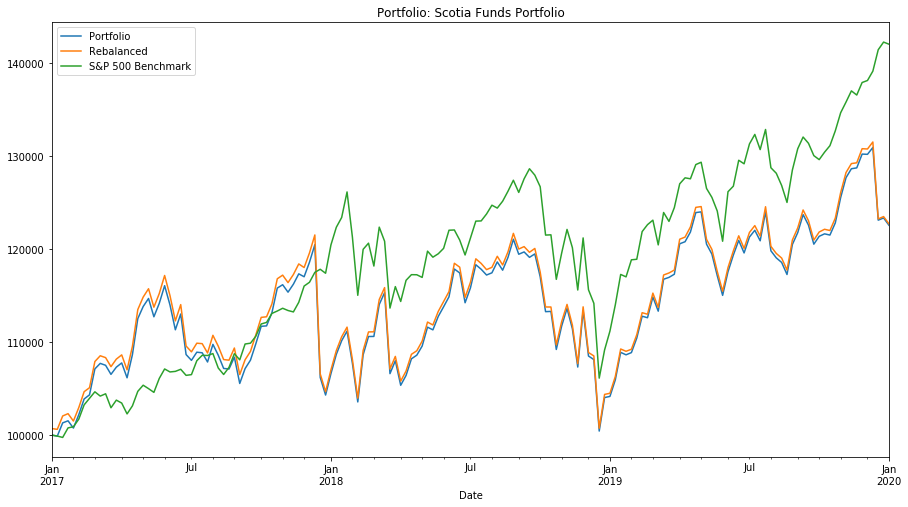




===Portfolio: Tech Stocks===
From 2017-01-05 to 2020-01-05

Initial Investment         = $100,000.00
        Holding     Shares        BookValue      %
           AAPL        170       20,000.00$  20.0%
           AMZN         25       20,000.00$  20.0%
           NFLX        153       20,000.00$  20.0%
             FB        162       20,000.00$  20.0%
          BRK-B        122       20,000.00$  20.0%

Total Portfolio            = $208,789.75 = +108,789.75$ = +108.79% (total) = +24.79% (annualized)
        Holding     Shares            Value      %
           AAPL        170       50,450.34$  24.2%
           AMZN         25       47,110.39$  22.6%
           NFLX        153       49,729.15$  23.8%
             FB        162       33,817.36$  16.2%
          BRK-B        122       27,682.51$  13.3%

Total Portfolio Rebalanced = $215,875.97 = +115,875.97$ = +115.88% (total) = +25.93% (annualized)
        Holding     Shares            Value      %
           AAPL        209       62

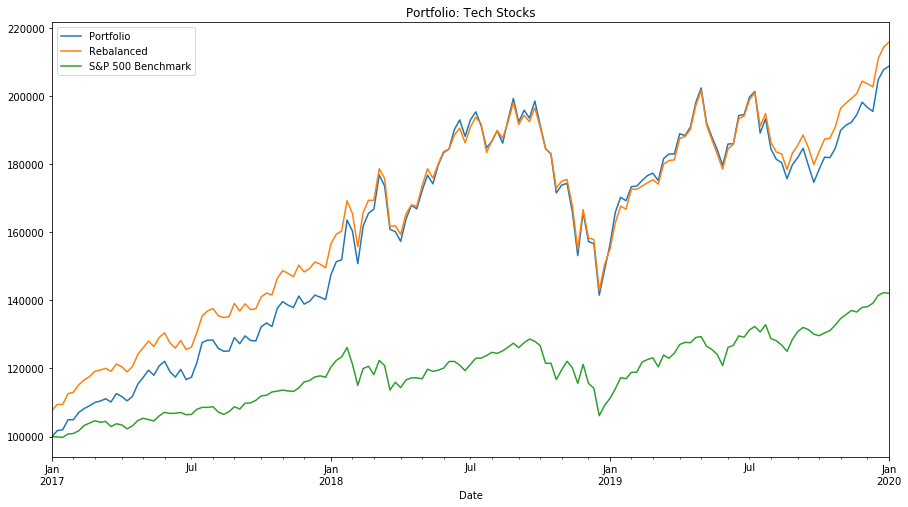

In [3]:

benchmark_data, benchmark_num_shares = download_portfolio_history(benchmark_portfolio, start, end)
portfolio_data, portfolio_num_shares = download_portfolio_history(portfolio, start, end)
rebalanced_num_shares = rebalance_portfolio(portfolio, portfolio_data, portfolio_num_shares, start, end)

plot_results(portfolio, portfolio_data, portfolio_num_shares, rebalanced_num_shares, benchmark_portfolio, benchmark_data, benchmark_num_shares)

# Portfolio:  Ticker, percentage of holdings, description
portfolio2 = {
    'name': 'Tech Stocks',
    'holdings': [
        Holding('AAPL', 20, ''),
        Holding('AMZN', 20, ''),
        Holding('NFLX', 20, ''),
        Holding('FB',   20, ''),
        Holding('BRK-B', 20, '')]
}

portfolio2_data, portfolio2_num_shares = download_portfolio_history(portfolio2, start, end)
rebalanced2_num_shares = rebalance_portfolio(portfolio2, portfolio2_data, portfolio2_num_shares, start, end)
plot_results(portfolio2, portfolio2_data, portfolio2_num_shares, rebalanced2_num_shares, benchmark_portfolio, benchmark_data, benchmark_num_shares)
